# Лабораторная работа №5
**Студент**: Суханов Е.А.

**Группа**: М8О-406Б-19

**Задание**: Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением . Исследовать зависимость погрешности от сеточных параметров.

**Вариант**: 7

**Вариант:** 7

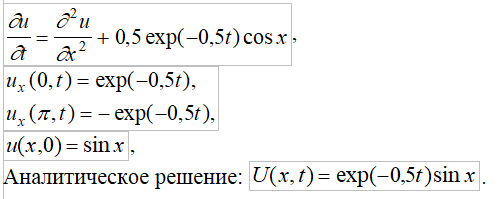

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Task():
    def __init__(self, u0, ul, l, ur, r, f, a):
        self.u0 = u0
        self.ul = ul
        self.l = l
        self.ur = ur
        self.r = r
        self.f = f
        self.a = a

# Вариант 7
task = Task(
    u0=lambda x: np.sin(x),
    ul=lambda t: np.exp(-0.5*t),
    l=0,
    ur=lambda t: -np.exp(-0.5*t),
    r=np.pi,
    f=lambda x,t: 0.5*np.exp(-0.5*t)*np.sin(x),
    a=1,
)

analytic_func = lambda x,t: np.exp(-0.5*t)*np.sin(x)

T_RES = 1000
H_RES = 20
END_TIME = 10

In [3]:
# Аналитическое решение
def analytic(l_bound, r_bound, func, end_time, t_res, h_res):
    h = (r_bound - l_bound) / h_res
    tau = end_time / t_res
    u = np.zeros(shape=(t_res, h_res))

    for t_itr in range(0, t_res):
        for x in range(0, h_res):
            u[t_itr][x] = func(l_bound + x * h, t_itr * tau)
    
    return u    

In [4]:
analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, T_RES, H_RES)
print(analytic_nodes)

[[0.         0.15643447 0.30901699 ... 0.4539905  0.30901699 0.15643447]
 [0.         0.15565424 0.30747577 ... 0.45172621 0.30747577 0.15565424]
 [0.         0.15487792 0.30594222 ... 0.44947322 0.30594222 0.15487792]
 ...
 [0.         0.00106998 0.00211361 ... 0.00310519 0.00211361 0.00106998]
 [0.         0.00106464 0.00210307 ... 0.00308971 0.00210307 0.00106464]
 [0.         0.00105933 0.00209258 ... 0.0030743  0.00209258 0.00105933]]


In [5]:
# Явная схема
def explicit(task: Task, end_time, t_res, h_res, approx='1p1'):
        h = (task.r - task.l) / h_res
        tau = end_time / t_res
        sigma = (task.a * tau)/(h**2)

        sigma = (task.a * tau)/(h**2)
        if sigma > 0.5:
            raise ValueError(f"Sigma: {sigma}")
        
        u = np.zeros((t_res, h_res))
        u[0] = task.u0(np.arange(task.l, task.r, h))

        for k in range(1, t_res):
            for j in range(1, h_res - 1):
                u[k][j] = sigma * u[k - 1][j + 1] + (1 - 2 * sigma) * u[k - 1][j] + sigma * u[k - 1][j - 1] 
                u[k][j] += tau * task.f(task.l + j * h, k * tau)
           
            if approx == '1p2':
                u[k][0] = u[k][1] - h * task.ul(k * tau)
                u[k][-1] = u[k][-2] + h * task.ur(k * tau)
                    
            elif approx == '2p2':
                u[k][0] = (u[k][1] - h * task.ul(k * tau) + (h ** 2 / (2 * tau) * u[k - 1][0])) / (1 + h ** 2 / (2 * tau))
                u[k][-1] = (u[k][-2] + h * task.ur(k * tau) + (h ** 2 / (2 * tau) * u[k - 1][-1])) / (1 + h ** 2 / (2 * tau))
        

            elif approx == '2p3':
                u[k][0] = (task.ul(k * tau) + u[k][2] / (2 * h) - 2 * u[k][1] / h) * 2 * h / -3
                u[k][-1] = (task.ur(k * tau) - u[k][-3] / (2 * h) + 2 * u[k][-2] / h) * 2 * h / 3

        return u


In [6]:
explicit_nodes = explicit(task, END_TIME, T_RES, H_RES, approx='2p3')
print(explicit_nodes)

[[0.00000000e+00 1.56434465e-01 3.09016994e-01 ... 4.53990500e-01
  3.09016994e-01 1.56434465e-01]
 [8.47826890e-04 1.55651606e-01 3.07470552e-01 ... 4.51718553e-01
  3.07470552e-01 1.55190422e-01]
 [1.29998327e-03 1.55216288e-01 3.05931874e-01 ... 4.49458014e-01
  3.05744964e-01 1.54162838e-01]
 ...
 [3.41577183e-04 1.40217202e-03 2.43517687e-03 ... 3.24311743e-03
  2.24489464e-03 1.19589383e-03]
 [3.41008345e-04 1.39631342e-03 2.42416609e-03 ... 3.22807460e-03
  2.23483042e-03 1.19106150e-03]
 [3.40442331e-04 1.39048403e-03 2.41321022e-03 ... 3.21310680e-03
  2.22481640e-03 1.18625329e-03]]


In [7]:
# Метод прогонки
def tridiagonal_matrix_algorithm(a, b, c, d):
    n = len(a)

    p = np.zeros(n)
    q = np.zeros(n)

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n):
        p[i] = -c[i] / (b[i] + a[i] * p[i - 1])
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])

    x = np.zeros(n)
    x[-1] = q[-1]

    for i in range(n - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x
    
# Неявная схема
def implicit(task: Task, end_time, t_res, h_res, approx='1p2'):
    h = (task.r - task.l) / h_res
    tau = end_time / t_res
    sigma = (task.a * tau)/(h**2)

    a = np.zeros(h_res)
    b = np.zeros(h_res)
    c = np.zeros(h_res)
    d = np.zeros(h_res)
    u = np.zeros((t_res, h_res))
    u[0] = task.u0(np.arange(task.l, task.r, h))

    for k in range(1, t_res):
        for j in range(1, h_res - 1):
            a[j] = sigma
            b[j] = -(1 + 2 * sigma)
            c[j] = sigma
            d[j] = -u[k - 1][j] - tau * task.f(task.l + j * h, k * tau)

        if approx == '1p2':
            a[0] = 0
            b[0] = -1 / h
            c[0] = 1 / h
            d[0] = task.ul(k * tau)
            a[-1] = -1 / h
            b[-1] = 1 / h
            c[-1] = 0
            d[-1] = task.ur(k * tau)

        elif approx == '2p2':  
            b[0] = 2 * task.a ** 2 / h + h / tau
            c[0] = - 2 * task.a ** 2 / h
            d[0] = (h / tau) * u[k - 1][0] - task.ul(k * tau) * 2 * task.a ** 2
            a[-1] = -2 * task.a ** 2 / h
            b[-1] = 2 * task.a ** 2 / h + h / tau
            d[-1] = (h / tau) * u[k - 1][-1] + task.ur(k * tau) * 2 * task.a ** 2
        elif approx == '2p3':
            k0 = 1 / (2 * h) / c[1]
            b[0] = (-3 / (2 * h) + a[1] * k0)
            c[0] = 2 / h + b[1] * k0
            d[0] = task.ul(k* tau) + d[1] * k0
            k1 = -(1 / (h * 2)) / a[-2]
            a[-1] = (-2 / h) + b[-2] * k1
            b[-1] = (3 / (h * 2)) + c[-2] * k1
            d[-1] = task.ur(k* tau) + d[-2] * k1

        u[k] = tridiagonal_matrix_algorithm(a, b, c, d)

    return u

In [8]:
implicit_nodes = implicit(task, END_TIME, T_RES, H_RES, approx='1p2')
print(implicit_nodes)

[[ 0.          0.15643447  0.30901699 ...  0.4539905   0.30901699
   0.15643447]
 [-0.00083396  0.15546224  0.30743925 ...  0.45141405  0.30610247
   0.14980628]
 [-0.00098262  0.15453405  0.30584977 ...  0.44871121  0.30346836
   0.1479517 ]
 ...
 [-0.01825156 -0.01717717 -0.01613233 ... -0.01546169 -0.01648509
  -0.01755948]
 [-0.01825279 -0.01718376 -0.01614414 ... -0.01547685 -0.01649514
  -0.01756417]
 [-0.01825402 -0.01719032 -0.01615588 ... -0.01549192 -0.01650514
  -0.01756884]]


In [9]:

# Кобинированный метод
def combined_method(task: Task, end_time, t_res, h_res, theta=0.5, approx='1p2'):
    h = (task.r - task.l) / h_res
    tau = end_time / t_res
    sigma = (task.a * tau)/(h**2)
    
    a = np.zeros(h_res)
    b = np.zeros(h_res)
    c = np.zeros(h_res)
    d = np.zeros(h_res)
    tmp_imp = np.zeros(h_res)
    u = np.zeros((t_res, h_res))

    u[0] = task.u0(np.arange(task.l, task.r, h))

    for k in range(1, t_res):
        for j in range(1, h_res - 1):
            a[j] = sigma
            b[j] = -(1 + 2 * sigma)
            c[j] = sigma
            d[j] = -u[k - 1][j] - tau * task.f(task.l + j * h, k * tau)

        if approx == '1p2': 
            a[0] = 0
            b[0] = -1 / h
            c[0] = 1 / h
            d[0] = task.ul(k * tau)
            a[-1] = -1 / h
            b[-1] = 1 / h
            c[-1] = 0
            d[-1] = task.ur(k * tau)

        elif approx == '2p2':  
            b[0] = 2 * task.a ** 2 / h + h / tau
            c[0] = - 2 * task.a ** 2 / h
            d[0] = (h / tau) * u[k - 1][0] - task.ul(k * tau) * 2 * task.a ** 2
            a[-1] = -2 * task.a ** 2 / h
            b[-1] = 2 * task.a ** 2 / h + h / tau
            d[-1] = (h / tau) * u[k - 1][-1] + task.ur(k * tau) * 2 * task.a ** 2
        elif approx == '2p3':
            k0 = 1 / (2 * h) / c[1]
            b[0] = (-3 / (2 * h) + a[1] * k0)
            c[0] = 2 / h + b[1] * k0
            d[0] = task.ul(k* tau) + d[1] * k0
            k1 = -(1 / (h * 2)) / a[-2]
            a[-1] = (-2 / h) + b[-2] * k1
            b[-1] = (3 / (h * 2)) + c[-2] * k1
            d[-1] = task.ur(k* tau) + d[-2] * k1

        tmp_imp = tridiagonal_matrix_algorithm(a, b, c, d)

        tmp_exp = np.zeros(h_res)
        for j in range(1, h_res - 1):
            tmp_exp[j] = sigma * u[k - 1][j + 1] + (1 - 2 * sigma) * u[k - 1][j] + sigma * u[k - 1][j - 1] + tau * task.f(task.l + j * h, k * tau)
            
        if approx == '1p2':
            tmp_exp[0] = u[k][1] - h * task.ul(k * tau)
            tmp_exp[-1] = u[k][-2] + h * task.ur(k * tau)
                
        elif approx == '2p2':
            tmp_exp[0] = (u[k][1] - h * task.ul(k * tau) + (h ** 2 / (2 * tau) * u[k - 1][0])) / (1 + h ** 2 / (2 * tau))
            tmp_exp[-1] = (u[k][-2] + h * task.ur(k * tau) + (h ** 2 / (2 * tau) * u[k - 1][-1])) / (1 + h ** 2 / (2 * tau))
            
        elif approx == '2p3':
            tmp_exp[0] = (task.ul(k * tau) + u[k][2] / (2 * h) - 2 * u[k][1] / h) * 2 * h / -3
            tmp_exp[-1] = (task.ur(k * tau) - u[k][-3] / (2 * h) + 2 * u[k][-2] / h) * 2 * h / 3
        
        u[k] = theta * tmp_imp + (1 - theta) * tmp_exp
    return u

In [10]:
combined_nodes = combined_method(task, END_TIME, T_RES, H_RES)
print(combined_nodes)

[[ 0.          0.15643447  0.30901699 ...  0.4539905   0.30901699
   0.15643447]
 [-0.07856508  0.15555692  0.3074549  ...  0.4515663   0.30678651
  -0.00324496]
 [-0.07821229  0.13880796  0.305884   ...  0.4490376   0.27268067
  -0.00350712]
 ...
 [-0.0025215  -0.00268068 -0.00229979 ... -0.00210537 -0.00251515
  -0.00243214]
 [-0.0025099  -0.00266911 -0.00229057 ... -0.00209712 -0.00250441
  -0.00242098]
 [-0.00249835 -0.00265758 -0.00228138 ... -0.00208889 -0.00249371
  -0.00240987]]


#### Сравнение методов

In [11]:
# Вывод графика ошибки
def draw_error(analytic, t_end, numericals, suffix_labels):

    t_res = analytic.shape[0]
    t = np.arange(0, t_end, t_end/t_res)
    for n,l in zip(numericals, suffix_labels):
        err = np.max(np.abs(analytic - n), axis=1)
        print(f"mean err {l}: {np.mean(err)}")
        plt.plot(t, err, label = f'Ошибка {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title('График изменения ошибки во времени')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.grid(True)
    plt.show()

mean err 1p2: 0.025763541107382423
mean err 2p2: 0.019995796292286497
mean err 2p3: 0.002268599643971792


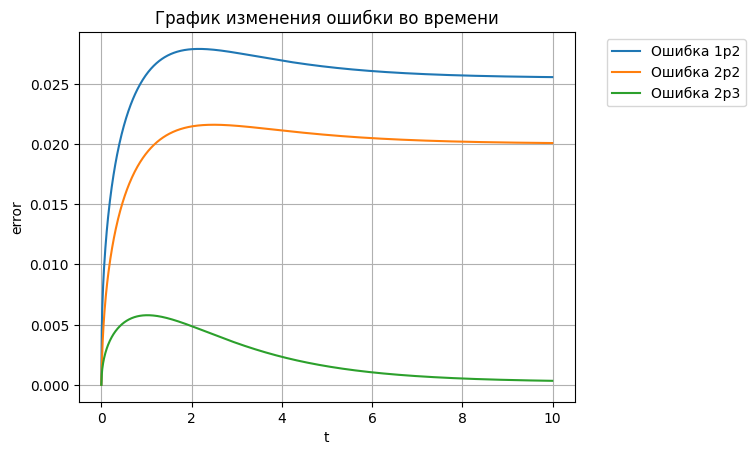

In [12]:
explicit_nodes_12 = explicit(task, END_TIME, T_RES, H_RES, approx='1p2')
explicit_nodes_22 = explicit(task, END_TIME, T_RES, H_RES, approx='2p2')
explicit_nodes_23 = explicit(task, END_TIME, T_RES, H_RES, approx='2p3')

draw_error(analytic_nodes,  END_TIME, [explicit_nodes_12, explicit_nodes_22, explicit_nodes_23], ['1p2', '2p2', '2p3'])

mean err 1p2: 0.02022978428305627
mean err 2p2: 0.014772002296248567
mean err 2p3: 0.007490723652054878


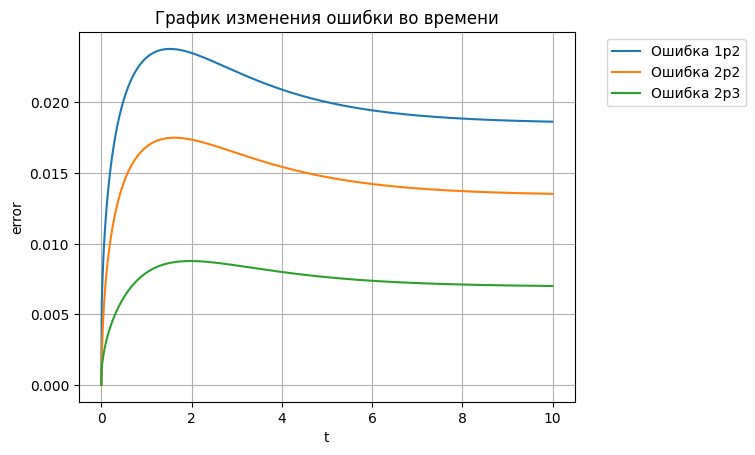

In [13]:
implicit_nodes_11 = implicit(task, END_TIME, T_RES, H_RES, approx='1p2')
implicit_nodes_12 = implicit(task, END_TIME, T_RES, H_RES, approx='2p2')
implicit_nodes_13 = implicit(task, END_TIME, T_RES, H_RES, approx='2p3')

draw_error(analytic_nodes,  END_TIME, [implicit_nodes_11, implicit_nodes_12, implicit_nodes_13], ['1p2', '2p2', '2p3'])

mean err 1p2: 0.06991329481779773
mean err 2p2: 0.06873143165799828
mean err 2p3: 0.05542924528798267


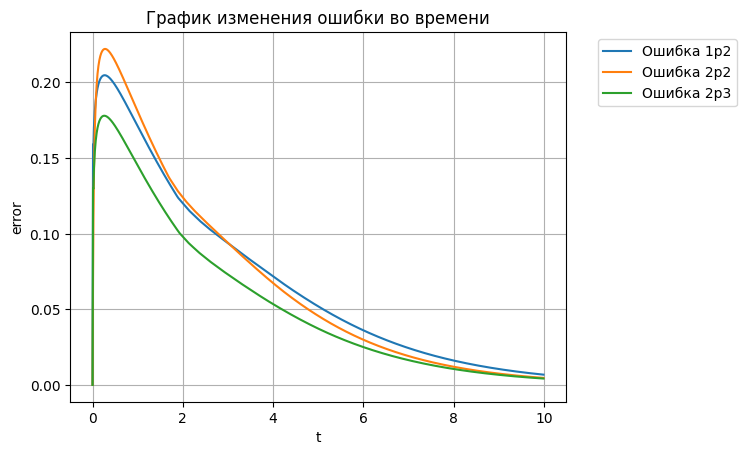

In [14]:
combined_nodes_11 = combined_method(task, END_TIME, T_RES, H_RES, approx='1p2')
combined_nodes_12 = combined_method(task, END_TIME, T_RES, H_RES, approx='2p2')
combined_nodes_13 = combined_method(task, END_TIME, T_RES, H_RES, approx='2p3')

draw_error(analytic_nodes,  END_TIME, [combined_nodes_11, combined_nodes_12, combined_nodes_13], ['1p2', '2p2', '2p3'])

#### Посмотрим на линии уровей

In [15]:
def draw_cmp_levels(analytic, a, b, end_time, curr_time, numericals, labels):
    t_res = analytic.shape[0]
    h_res = analytic.shape[1]

    h = (b - a) / h_res
    tau = end_time / t_res

    curr_t_idx = int(curr_time / tau)
    curr_time = curr_t_idx * tau
    
    x = np.arange(a, b, h)
    plt.plot(x, analytic[curr_t_idx], label = f'Линия уровня аналитического решения')
    for n,l in zip(numericals, labels):
        plt.plot(x, n[curr_t_idx], label = f'Линия уровня {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title(f'График линий уровня в момент времени t = {curr_time}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.grid(True)
    plt.show()

def draw_cmp_levels_helper(time):
    explicit_nodes = explicit(task, END_TIME, T_RES, H_RES, approx='2p3')
    implicit_nodes = implicit(task, END_TIME, T_RES, H_RES, approx='2p3')
    combined_nodes = combined_method(task, END_TIME, T_RES, H_RES, approx='2p3')
    draw_cmp_levels(analytic_nodes, task.l, task.r,  END_TIME, time, [explicit_nodes, implicit_nodes, combined_nodes], ['явного метода', 'неявного метода', 'комбинированного метода'])
    

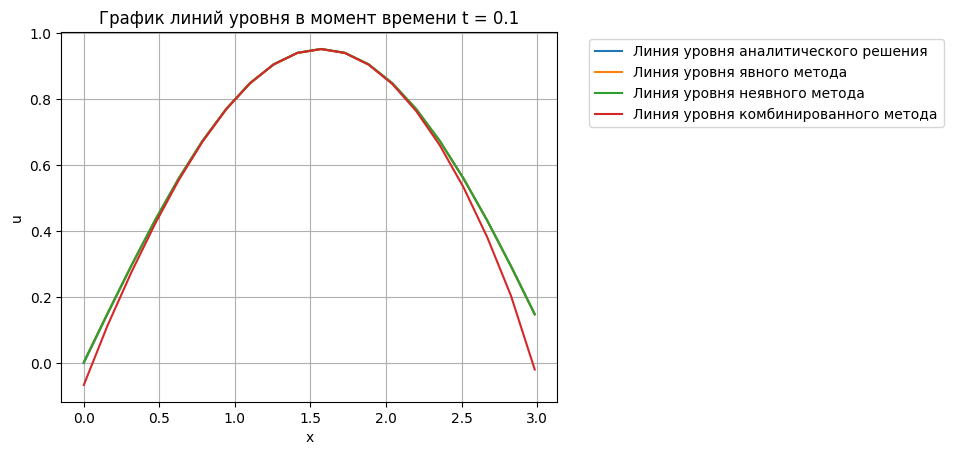

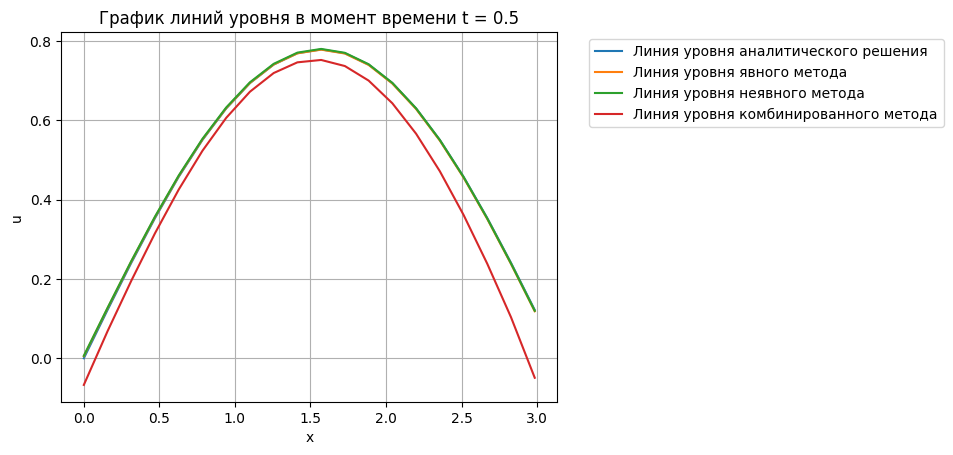

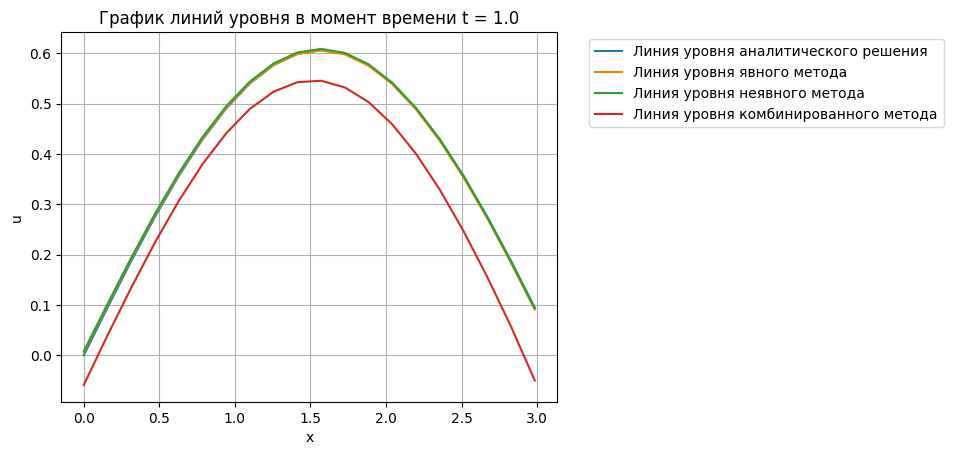

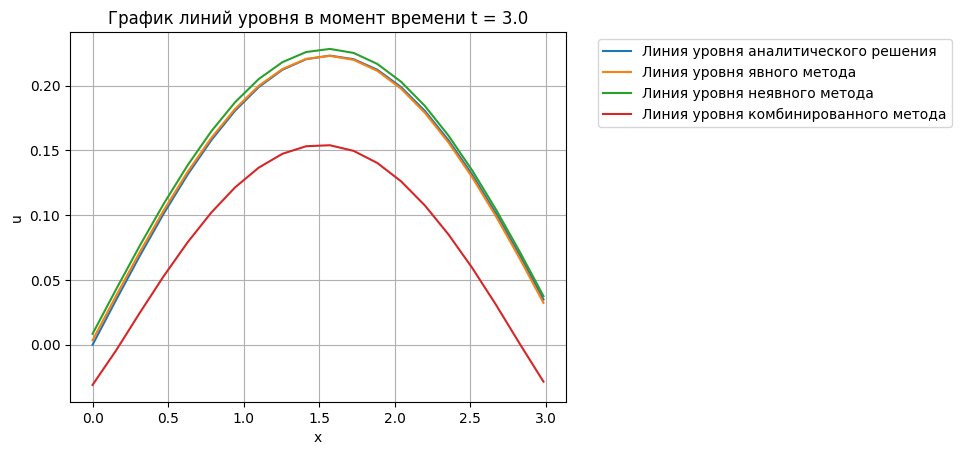

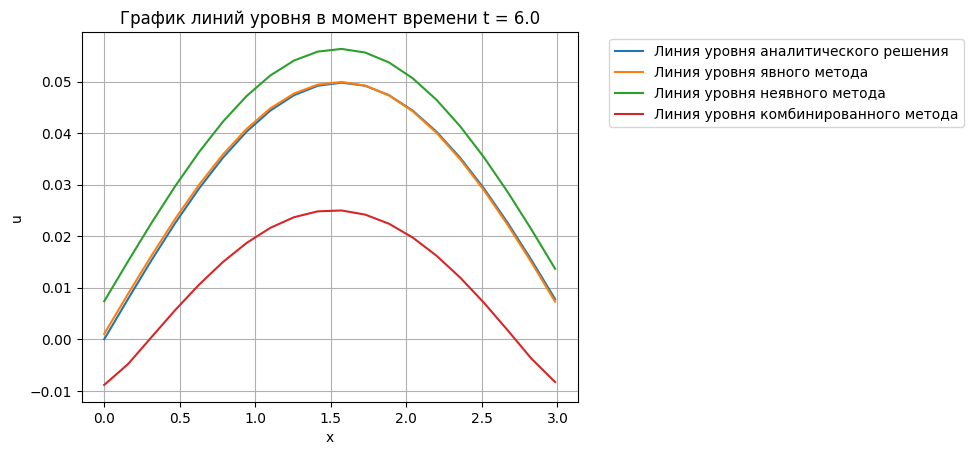

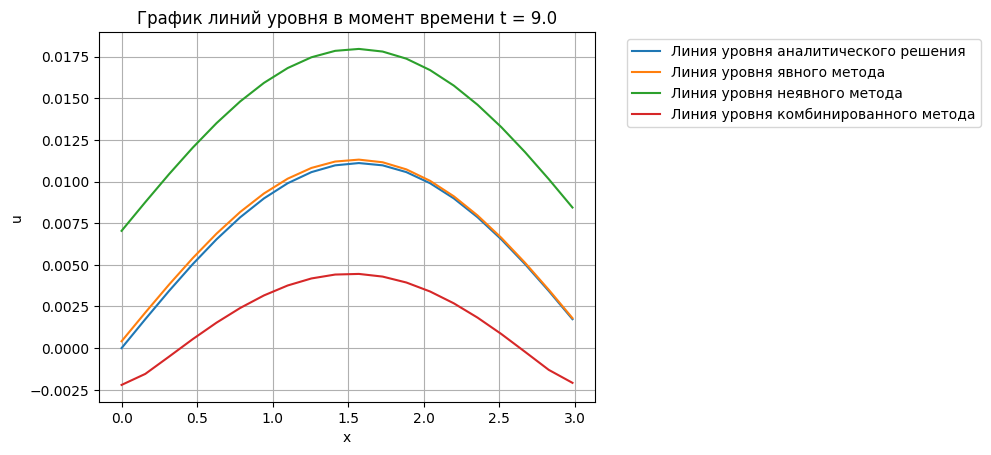

In [16]:
draw_cmp_levels_helper(0.1)
draw_cmp_levels_helper(0.5)
draw_cmp_levels_helper(1)
draw_cmp_levels_helper(3)
draw_cmp_levels_helper(6)
draw_cmp_levels_helper(9)

#### Исследование зависимости погрешности от сеточных параметров tau и h

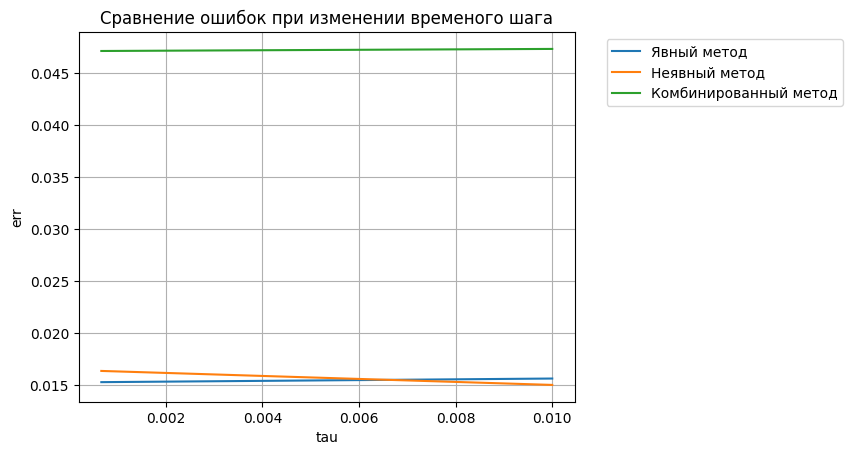

In [17]:
# Исследуем зависимость от tau при неизменном h
# tau зависит от t_res: чем больше t_res => тем меньше tau
H_RES = 20
T_RES_MIN = 1000
T_RES_MAX = 15000
T_RES_STEP = 500
END_TIME = 10
t_res_list = [t_res for t_res in range(T_RES_MIN, T_RES_MAX + T_RES_STEP // 2, T_RES_STEP)]

tau_list = [END_TIME / t_res for t_res in t_res_list]
exp_v = []
imp_v = []
com_v = []
for t_res in t_res_list:
    analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, t_res, H_RES)
    explicit_nodes = explicit(task, END_TIME, t_res, H_RES)
    implicit_nodes = implicit(task, END_TIME, t_res, H_RES)
    combined_nodes = combined_method(task, END_TIME, t_res, H_RES)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    exp_v.append(get_err(explicit_nodes))
    imp_v.append(get_err(implicit_nodes)) 
    com_v.append(get_err(combined_nodes))

plt.plot(tau_list, exp_v, label = 'Явный метод')
plt.plot(tau_list, imp_v, label = 'Неявный метод')
plt.plot(tau_list, com_v, label = 'Комбинированный метод')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении временого шага')
plt.xlabel('tau')
plt.ylabel('err')
plt.grid(True)
plt.show()

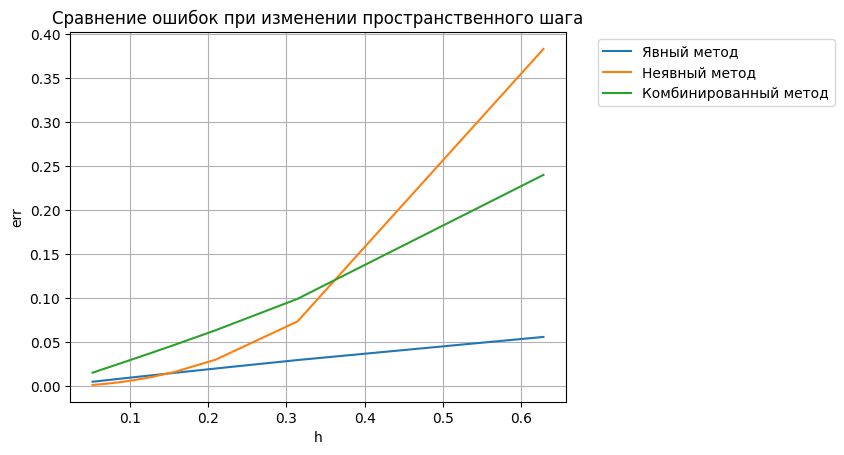

In [18]:
# Исследуем зависимость от h при неизменном tau
# h зависит от h_res: чем больше h_res => тем меньше h
T_RES = 10000
H_RES_MIN = 5
H_RES_MAX = 60
H_RES_STEP = 5
END_TIME = 10
h_res_list = [h_res for h_res in range(H_RES_MIN, H_RES_MAX + H_RES_STEP // 2, H_RES_STEP)]

h_list = [(task.r - task.l) / h_res for h_res in h_res_list]
exp_v = []
imp_v = []
com_v = []
for h_res in h_res_list:
    analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, T_RES, h_res)
    explicit_nodes = explicit(task, END_TIME, T_RES, h_res)
    implicit_nodes = implicit(task, END_TIME, T_RES, h_res)
    combined_nodes = combined_method(task, END_TIME, T_RES, h_res)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    exp_v.append(get_err(explicit_nodes))
    imp_v.append(get_err(implicit_nodes)) 
    com_v.append(get_err(combined_nodes))

plt.plot(h_list, exp_v, label = 'Явный метод')
plt.plot(h_list, imp_v, label = 'Неявный метод')
plt.plot(h_list, com_v, label = 'Комбинированный метод')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении пространственного шага')
plt.xlabel('h')
plt.ylabel('err')
plt.grid(True)
plt.show()

### Выводы

Как видно из сравнений аппроксимаций, 3-х точечная аппроксимация второго порядка дает наименьшую ошибку.

Явный метод показывает наименьшую ошибку, однако на него накладываются ограничения на максимальный шаг сетки. Так как при сигме большей 0.5 метод теряет устойчивость.

Как видно по графикам, уменьшение временного шага незначительно влияет на точность. Однако, возможно это из-за того, что на графике слишком мало данных. Пространственный шаг влияет прямо пропорционально на ошибку. 